In [1]:
import pandas as pd
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup
import seaborn as sns
import pysam, os, glob, skbio, math, random
from scipy import stats

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [3]:
rootdir = "/scratch/groups/dekas/OC17_metagenomics_2022/"

## contig taxonomy

In [4]:
udir = rootdir + "protein/ureC/contig_taxonomy/"
cmdir(udir)

### get/drep contigs across samples

In [11]:
cmdir(udir + "real_contigs")

In [6]:
### full set
extracted = pd.read_csv(rootdir + "urec-oc1703a-malaspina/data/urec_filter/urec_database_details.csv")
extracted["sample"] = extracted["seq_names"].apply(lambda x: x.split("_sens_")[0])

for sample in extracted.query("urec==True")["sample"].unique():
    
    # find assembly
    path = rootdir + "assembly/clean/%s_sens_min1000.contigs.fa" %(sample)

    # get assembly
    tmp = {}
    for record in sfp(open(path)):
        tmp[record[0].split(" ")[0]] = str(record[1])
            
    scaffolds = list(extracted[extracted["sample"]==sample].query("urec==True")["seq_names"].unique())
    
    for scaffold in scaffolds:
        with open(udir + "real_contigs/" + scaffold + ".fna", "w") as out:
             out.write(">%s\n%s\n" %(scaffold, tmp[scaffold]))
                
tmp = {}

In [7]:
call = "dRep compare -g %s -p 20 -pa 0.80 -sa 0.95 --clusterAlg single %s" %(udir + "real_contigs/*", udir + "drep")
print(call)

dRep compare -g /scratch/groups/dekas/OC17_metagenomics_2022/protein/ureC/contig_taxonomy/real_contigs/* -p 20 -pa 0.80 -sa 0.95 --clusterAlg single /scratch/groups/dekas/OC17_metagenomics_2022/protein/ureC/contig_taxonomy/drep


In [7]:
cclust = pd.read_csv(udir + "drep/data_tables/Cdb.csv")
len(cclust["secondary_cluster"].unique())

341

### annotate proteins

In [13]:
cmdir(udir + "diamond")
cmdir(udir + "diamond/parts")

In [12]:
df = extracted.query("urec==True")
col = "seq_names"

with open(udir + "diamond/real_scaffold_proteins.faa", "w") as out:
    
    for sample in df["sample"].unique():

        table = df[df["sample"]==sample]
        ppath = glob.glob(rootdir + "prodigal/" + sample + "_sens_min1000.contigs.faa")[0]
        tmp = {record[0].split(" ")[0]: str(record[1]) \
                   for record in sfp(open(ppath))}

        tmp2 = {}
        for key in tmp.keys():
            scaf = "_".join(key.split("_")[:-1])
            if scaf not in tmp2:
                tmp2[scaf] = [key]
            else: tmp2[scaf].append(key)

        for scaf in table[col].unique():
            for item in tmp2[scaf]:
                out.write(">%s\n%s\n" %(item, tmp[item]))

In [18]:
# split and launch diamond
records = [r for r in sfp(open(udir + "diamond/real_scaffold_proteins.faa"))]
wrapper = open(udir + "diamond/diamond.sh", "w")

n = math.ceil(len(records)/30)
for i in range(0, len(records),n):
    
    # write partial faa
    with open(udir + "diamond/parts/part" + str(int(i/n)+1) + ".faa", "w") as chunk:
        for record in records[i:i + n]:
            chunk.write(">%s\n%s\n" %(record[0], str(record[1])))
    
    # generate diamond call
    call = "diamond blastp -d /$OAK/db/uniref100.dmnd -q %s -o %s --threads 20 -b8 -c1" \
            %(udir + "diamond/parts/part" + str(int(i/n)+1) + ".faa",
              udir + "diamond/parts/part" + str(int(i/n)+1) + ".txt")
    cmd = sbatch("dmnd", 20, call)
    wrapper.write(cmd + "\n")

wrapper.close()

In [8]:
# concatenate + collect taxonomy
dmnd = pd.concat([skbio.io.read(item, format="blast+6", into=pd.DataFrame, default_columns=True) \
                      for item in glob.glob(udir + "diamond/parts/part*.txt")])
# compute coverage
faalens = {record[0].split(" ")[0]: len(record[1]) for record \
           in sfp(open(udir + "diamond/real_scaffold_proteins.faa"))}
dmnd["qlen"] = dmnd["qseqid"].map(faalens)
dmnd["qcov"] = dmnd.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
# choose best hits for each
dmnd = dmnd.sort_values(["bitscore", "qcov"], ascending=[False,False]).drop_duplicates("qseqid")
# filter for min cov /eval
dmnd = dmnd[(dmnd["evalue"]<1e-20) & (dmnd["qcov"]>0.70)]
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov
31666,OC1703_4500m_2000m_sens_contig_945622_21,UniRef100_A0A5E6R3Q4,98.1,4332.0,81.0,0.0,1.0,4332.0,1.0,4332.0,0.0,8429.0,4333,0.999538
31871,OC1703_3000m_500m_sens_contig_2403464_31,UniRef100_UPI000C88DF8D,100.0,2881.0,0.0,0.0,1.0,2881.0,1.0,2881.0,0.0,5744.0,2882,0.999306
4029,OC1703_3000m_50m_sens_contig_3749701_33,UniRef100_UPI000C88DF8D,100.0,2881.0,0.0,0.0,1.0,2881.0,1.0,2881.0,0.0,5744.0,2882,0.999306
36131,OC1703_3000m_3000m_sens_contig_271068_2,UniRef100_UPI0015E28905,100.0,2313.0,0.0,0.0,1.0,2313.0,1.0,2313.0,0.0,4561.0,2314,0.999136
12929,OC1703_4500m_2000m_sens_contig_2218076_17,UniRef100_UPI000BA31F2C,98.8,2365.0,28.0,0.0,1.0,2365.0,1.0,2365.0,0.0,4555.0,2366,0.999155


### get taxonomy

In [83]:
# map to uniref ids
with open(udir + "diamond/uniref_ids.txt", "w") as out:
    for uid in dmnd["sseqid"].unique():
        out.write(uid.split("_")[1] + "\n")

N.B. need to do two searches, one for uniref and one for uniparc.

In [9]:
uniref = pd.read_csv(udir + "diamond/uniref_idmapping.tsv", sep="\t")
uniref.columns = ["from", "entry", "organism", "organism_id"]
uniref["organism_id"] = uniref["organism_id"].apply(lambda x: str(x))
uniparc = pd.read_csv(udir + "diamond/uniparc_idmapping.tsv", sep="\t")
uniparc.columns = ["from", "entry", "organism", "organism_id"]
uni = pd.concat([uniref, uniparc]).fillna("None")
uni["taxid"] = uni["organism_id"].apply(lambda x: stats.mode(x.split("; "))[0][0])
uni.tail()

,from,entry,organism,organism_id,taxid
906,UPI000732158F,UPI000732158F,Pseudomonas fluorescens; Pseudomonas fluorescens,294; 294,294
907,UPI001B3439E0,UPI001B3439E0,Pseudomonas protegens,380021,380021
908,UPI001BB016DC,UPI001BB016DC,Marinomonas sp. CT5; Marinomonas sp. CT5,2066133; 2066133,2066133
909,UPI0002319E8B,UPI0002319E8B,Pseudoalteromonas sp. BSi20480; unclassified P...,386428; 194690; 386428; 386428; 386428; 386428...,386428
910,UPI0021F8827D,UPI0021F8827D,Rheinheimera sp. MM224; Rheinheimera sp.,3019969; 1869214,1869214


In [54]:
with open(udir + "diamond/ncbi_tax.txt", "w") as out:
    for tax in uni["taxid"].unique():
        out.write(tax + "\n")

In [ ]:
lineage_info = defaultdict(list)

for xml in glob.glob(udir + "/diamond/*xml"):
    
    for block in BeautifulSoup(open(xml), "xml").findAll("Taxon"):
        
        lineage, phylum = "None", "None"

        if block.find("Lineage"):
            lineage = block.find("Lineage").string

        for level in block.findAll("Taxon"):
            if level.find("Rank").string=="phylum":
                phylum = level.find("ScientificName").string

        lineage_info["taxid"].append(block.find("TaxId").string)
        lineage_info["lineage"].append(lineage)
        lineage_info["phylum"].append(phylum)

lineage_df = pd.DataFrame(lineage_info).query("lineage!='None'")
uni = uni.merge(lineage_df, how="left", on="taxid")
uni.head()

In [11]:
# add back in
dmnd["scaffold"] = dmnd["qseqid"].apply(lambda x: "_".join(x.split("_")[:-1]))
dmnd["entry"] = dmnd["sseqid"].apply(lambda x: x.split("_")[1])
dmnd = dmnd.merge(uni[["entry", "phylum"]], how="left").fillna("None")
# fix above
dmnd = dmnd[dmnd["scaffold"].isin(extracted.query("urec==True")["seq_names"].unique())]
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov,scaffold,entry,phylum
1,OC1703_3000m_500m_sens_contig_2403464_31,UniRef100_UPI000C88DF8D,100.0,2881.0,0.0,0.0,1.0,2881.0,1.0,2881.0,0.0,5744.0,2882,0.999306,OC1703_3000m_500m_sens_contig_2403464,UPI000C88DF8D,Pseudomonadota
2,OC1703_3000m_50m_sens_contig_3749701_33,UniRef100_UPI000C88DF8D,100.0,2881.0,0.0,0.0,1.0,2881.0,1.0,2881.0,0.0,5744.0,2882,0.999306,OC1703_3000m_50m_sens_contig_3749701,UPI000C88DF8D,Pseudomonadota
3,OC1703_3000m_3000m_sens_contig_271068_2,UniRef100_UPI0015E28905,100.0,2313.0,0.0,0.0,1.0,2313.0,1.0,2313.0,0.0,4561.0,2314,0.999136,OC1703_3000m_3000m_sens_contig_271068,UPI0015E28905,Pseudomonadota
4,OC1703_4500m_2000m_sens_contig_2218076_17,UniRef100_UPI000BA31F2C,98.8,2365.0,28.0,0.0,1.0,2365.0,1.0,2365.0,0.0,4555.0,2366,0.999155,OC1703_4500m_2000m_sens_contig_2218076,UPI000BA31F2C,Pseudomonadota
5,OC1703_3000m_1000m_sens_contig_2825716_12,UniRef100_UPI0015E28905,99.9,2313.0,3.0,0.0,1.0,2313.0,1.0,2313.0,0.0,4554.0,2314,0.999136,OC1703_3000m_1000m_sens_contig_2825716,UPI0015E28905,Pseudomonadota


### reconcile

In [12]:
orf_counts = {}

for record in sfp(open(udir + "diamond/real_scaffold_proteins.faa")):
    scaf = "_".join(record[0].split("_")[:-1])
    if scaf not in orf_counts:
        orf_counts[scaf] = 1
    else: orf_counts[scaf] +=1
    
len(orf_counts.keys())

5690

In [13]:
tax_info = defaultdict(list)

for scaf in dmnd["scaffold"].unique():
    
    subtable = dmnd[dmnd["scaffold"]==scaf].groupby(["scaffold", "phylum"], \
        as_index=False).aggregate({"qseqid":"count"}).sort_values("qseqid", ascending=False)
    subtable["total_orfs"] = orf_counts[subtable["scaffold"].iloc[0]]
    subtable["perc_orfs"] = subtable.apply(lambda x: x["qseqid"]/x["total_orfs"], axis=1)
    sorted_table = subtable.sort_values("perc_orfs", ascending=False)
    tax_info["scaffold"].append(sorted_table["scaffold"].iloc[0])
    tax_info["prot_phylum_winner"].append(sorted_table["phylum"].iloc[0])
    tax_info["prot_phylum_winner_perc"].append(sorted_table["perc_orfs"].iloc[0])

tax_info_df = pd.DataFrame(tax_info)
tax_info_df.tail()

,scaffold,prot_phylum_winner,prot_phylum_winner_perc
1795,OC1703_4500m_1000m_sens_contig_1902572,Nitrospinota,0.333333
1796,OC1703_4500m_3000m_sens_contig_3530469,Pseudomonadota,1.000000
1797,OC1703_3000m_150m_sens_contig_3866675,None,0.500000
1798,OC1703_4500m_1000m_sens_contig_3043723,Verrucomicrobiota,0.666667
1799,OC1703_4500m_500m_sens_contig_5062989,None,0.500000


### curate

In [13]:
tmerge = tax_info_df

tmp = {}
for contig in glob.glob(udir + "real_contigs/*"):
    for record in sfp(open(contig)):
        tmp[record[0]]=len(record[1])
tmerge["scaffold_len"] = tmerge["scaffold"].map(tmp)
tmp = {}

In [14]:
binned = pd.read_csv(rootdir + "protein/ureC/urec_binned_contigs.tsv", sep="\t")
tmerge = tmerge.merge(binned[["scaffold", "classification"]], how="left").fillna("None")
tmerge = tmerge.rename(columns={"classification":"bin_classification"})

In [15]:
cclust["scaffold"] = cclust["genome"].apply(lambda x: x.replace(".fna", ""))
tmerge = tmerge.merge(cclust[["scaffold", "primary_cluster","secondary_cluster"]], how="left").fillna("not clustered")
tmerge[["scaffold", "scaffold_len", "primary_cluster", "secondary_cluster", \
        "prot_phylum_winner", "prot_phylum_winner_perc", "bin_classification"]].sort_values(["primary_cluster", \
        "secondary_cluster", "scaffold_len"], ascending=[True,True,False]).to_csv(udir + "diamond/to_curate.csv", index=False)

In [14]:
# read back in
def reconcile_taxonomy(row):
    if row["manual"]!='None':
        return row["manual"]
    elif row["prot_phylum_winner"] == 'None':
        return "unclassified"
    else: return row["prot_phylum_winner"]
        
curated = pd.read_csv(udir + "diamond/curated.csv").fillna("None")
curated["reconciled_taxonomy"] = curated.apply(reconcile_taxonomy, axis=1)
curated.query("manual=='None'").head(10)

,scaffold,scaffold_len,primary_cluster,secondary_cluster,prot_phylum_winner,prot_phylum_winner_perc,bin_classification,manual,reconciled_taxonomy
0,OC1703_4500m_500m_sens_contig_3438907,11706,1,1_0,Chloroflexota,0.833333,None,None,Chloroflexota
1,OC1703_3000m_1000m_sens_contig_1343963,290156,2,2_1,Proteobacteria,0.950758,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,Proteobacteria
2,OC1703_3000m_3000m_sens_contig_701093,133857,2,2_1,Proteobacteria,0.896825,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,Proteobacteria
3,OC1703_4500m_2000m_sens_contig_1752643,19664,2,2_1,Proteobacteria,0.956522,None,None,Proteobacteria
4,OC1703_3000m_50m_sens_contig_1313614,9557,3,3_1,Proteobacteria,1.000000,None,None,Proteobacteria
5,OC1703_4500m_50m_sens_contig_6005247,5078,3,3_1,Proteobacteria,1.000000,None,None,Proteobacteria
8,OC1703_3000m_50m_sens_contig_1315830,123315,7,7_1,Proteobacteria,0.958678,None,None,Proteobacteria
9,OC1703_3000m_500m_sens_contig_5191787,123314,7,7_1,Proteobacteria,0.958678,None,None,Proteobacteria
10,OC1703_3000m_1000m_sens_contig_3276135,123314,7,7_1,Proteobacteria,0.958678,None,None,Proteobacteria
11,OC1703_3000m_150m_sens_contig_1823447,35336,7,7_1,Proteobacteria,0.948718,None,None,Proteobacteria


In [15]:
# how many euks?
curated.query("manual=='eukaryote'")

,scaffold,scaffold_len,primary_cluster,secondary_cluster,prot_phylum_winner,prot_phylum_winner_perc,bin_classification,manual,reconciled_taxonomy
6,OC1703_3000m_50m_sens_contig_2514702,9169,6,6_1,Chlorophyta,0.833333,None,eukaryote,eukaryote
7,OC1703_4500m_50m_sens_contig_6461713,8500,6,6_1,Chlorophyta,1.000000,None,eukaryote,eukaryote
115,OC1703_3000m_50m_sens_contig_22604,4402,65,65_1,Chlorophyta,0.500000,None,eukaryote,eukaryote
116,OC1703_4500m_50m_sens_contig_4421038,4060,65,65_1,Chlorophyta,0.500000,None,eukaryote,eukaryote
662,OC1703_4500m_50m_sens_contig_2626437,3347,176,176_0,None,1.000000,None,eukaryote,eukaryote


/home/users/ajaffe/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


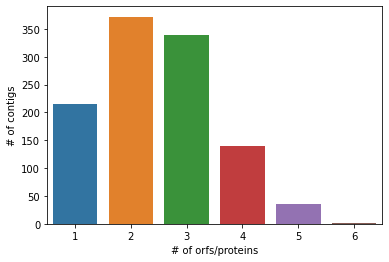

In [16]:
# argument for removing scafs < 3 kb
curated["orf_counts"] = curated["scaffold"].map(orf_counts)
cgb = curated.query("scaffold_len<3000").groupby("orf_counts", as_index=False).aggregate("count")
sns.barplot("orf_counts", "manual", data = cgb)
plt.ylabel("# of contigs")
plt.xlabel("# of orfs/proteins")
plt.show()

### calculate rel. abund.

In [207]:
cmdir(udir + "abund")

In [17]:
working_set = curated.query("scaffold_len>3000").query("manual!='eukaryote'")
working_set["sample"] = working_set["scaffold"].apply(lambda x: "_".join(x.split("_")[0:3]))
working_set.head(2)

,scaffold,scaffold_len,primary_cluster,secondary_cluster,prot_phylum_winner,prot_phylum_winner_perc,bin_classification,manual,reconciled_taxonomy,orf_counts,sample
0,OC1703_4500m_500m_sens_contig_3438907,11706,1,1_0,Chloroflexota,0.833333,None,None,Chloroflexota,12,OC1703_4500m_500m
1,OC1703_3000m_1000m_sens_contig_1343963,290156,2,2_1,Proteobacteria,0.950758,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,Proteobacteria,264,OC1703_3000m_1000m


In [63]:
# get coverage info 
with open(udir + "/abund/runCoverM.sh", "w") as outfile:
    
    for sample in working_set["sample"].unique():
        
        sample_id = "".join(sample.split("_")[1:3]) 
        # find self mapping
        mapping = "/scratch/groups/dekas/Nestor/new_ind_assembly/%s_mapped.bam" %(sample_id)
        sorted_bam = udir + "abund/" + sample_id + "_mapped.sorted.bam"
        sort = "samtools sort --threads 20 %s > %s" %(mapping, sorted_bam)
        index = "samtools index -@ 20 %s" %(sorted_bam)
        call = "coverm contig -t 20 -b %s --min-covered-fraction 0 --min-read-percent-identity 0.95 --output-format sparse -m count mean covered_fraction length > %s" %(sorted_bam, \
            udir + "abund/A" + sample_id + "_coverage_info.csv")
        outfile.write(sbatch("coverm", 20, " && ".join([sort, index, call])) + "\n")

In [18]:
#assemblies
amapping = pd.concat([pd.read_csv(item, sep="\t") for item \
                      in glob.glob(udir + "abund/A*_info.csv")]).rename(columns={"Contig": "scaffold", "Read Count": "read_count", "Mean": "mean_coverage", "Covered Fraction": "breadth"})
working_set = working_set.merge(amapping[["scaffold", "read_count", "mean_coverage", "breadth"]])
wgb = working_set.query("breadth>0.50").groupby(["sample"], as_index=False).aggregate({"read_count":"sum", "mean_coverage": "sum"}).rename(columns={"read_count": "total_read_count", "mean_coverage":"total_coverage"})
working_set = working_set.query("breadth>0.50").merge(wgb, how="left")
working_set["read_fraction"] = working_set.apply(lambda x: (x["read_count"]/x["total_read_count"]), axis=1)
working_set["coverage_fraction"] = working_set.apply(lambda x: (x["mean_coverage"]/x["total_coverage"]), axis=1)
working_set.head()

,scaffold,scaffold_len,primary_cluster,secondary_cluster,prot_phylum_winner,prot_phylum_winner_perc,bin_classification,manual,reconciled_taxonomy,orf_counts,sample,read_count,mean_coverage,breadth,total_read_count,total_coverage,read_fraction,coverage_fraction
0,OC1703_4500m_500m_sens_contig_3438907,11706,1,1_0,Chloroflexota,0.833333,None,None,Chloroflexota,12,OC1703_4500m_500m,723,8.810056,1.000000,97378,2090.536231,0.007425,0.004214
1,OC1703_3000m_1000m_sens_contig_1343963,290156,2,2_1,Proteobacteria,0.950758,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,Proteobacteria,264,OC1703_3000m_1000m,38955,18.916164,0.999697,558981,3078.515115,0.069689,0.006145
2,OC1703_3000m_3000m_sens_contig_701093,133857,2,2_1,Proteobacteria,0.896825,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,Proteobacteria,126,OC1703_3000m_3000m,16587,17.429530,0.999873,313352,3891.659707,0.052934,0.004479
3,OC1703_4500m_2000m_sens_contig_1752643,19664,2,2_1,Proteobacteria,0.956522,None,None,Proteobacteria,23,OC1703_4500m_2000m,1915,13.774572,0.998983,369313,4872.168753,0.005185,0.002827
4,OC1703_3000m_50m_sens_contig_1313614,9557,3,3_1,Proteobacteria,1.000000,None,None,Proteobacteria,12,OC1703_3000m_50m,1367,20.272139,1.000000,584986,1204.464376,0.002337,0.016831


In [21]:
working_set.to_csv(rootdir + "tables/contig_working_set.tsv", sep="\t", index=False)